# Supervised Regression

## Problem Statement
Using Deep Learning techniques, predict the coordinates (x, y) of a single pixel with a value of 255 in a 50x50 grayscale image where all other pixels are 0.

## Installation & Setup
To run this notebook, ensure you have Python 3.x installed. You can install the necessary dependencies using the following command:

```bash
pip install -r requirements.txt
```

The required libraries include:
- `numpy`
- `torch` (PyTorch)
- `matplotlib`
- `scikit-learn`
- `tqdm`

## Dataset Choice Rationale

1. **Synthetic Data Generation**: Since the problem specifies a deterministic rule (one random pixel is 255, others 0), we generate the dataset synthetically. This allows us to create a balanced and large enough dataset for training.
2. **Sample Size**: We use 10,000 samples. Given a 50x50 search space (2,500 possible positions), 10,000 samples provide multiple examples of each position, helping the model generalize beyond simple memorization.
3. **Normalization**:
   - **Images**: Pixel values are normalized from [0, 255] to [0, 1] to provide stable input for the neural network.
   - **Targets**: Coordinates (x, y) are normalized from [0, 49] to [0, 1]. Normalizing targets in regression helps the optimizer converge faster as the loss values stay within a manageable range.
4. **Supervised Approach**: We treat this as a standard regression problem. A Convolutional Neural Network (CNN) is chosen because it is naturally suited for spatial feature extraction from images.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split


In [4]:
def generate_sample(image_size=50):
    """
    Generates one image with a single bright pixel.
    Returns:
        image: (50, 50)
        target: (x, y)
    """
    image = np.zeros((image_size, image_size), dtype=np.float32)

    x = np.random.randint(0, image_size)
    y = np.random.randint(0, image_size)

    image[y, x] = 255.0

    return image, np.array([x, y], dtype=np.float32)


In [5]:
def create_dataset(num_samples=10000):
    images = []
    targets = []

    for _ in tqdm(range(num_samples)):
        img, coord = generate_sample()
        images.append(img)
        targets.append(coord)

    return np.array(images), np.array(targets)


In [6]:
X, y = create_dataset(num_samples=10000)

print(X.shape)  # (10000, 50, 50)
print(y.shape)  # (10000, 2)


100%|██████████| 10000/10000 [00:00<00:00, 251390.76it/s]

(10000, 50, 50)
(10000, 2)


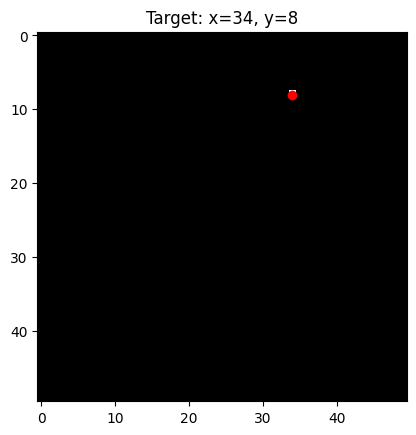

In [7]:
idx = np.random.randint(0, len(X))

plt.imshow(X[idx], cmap="gray")
plt.scatter(y[idx][0], y[idx][1], c="red")
plt.title(f"Target: x={int(y[idx][0])}, y={int(y[idx][1])}")
plt.show()


In [8]:
class PixelDataset(Dataset):
    def __init__(self, images, targets):
        self.images = images / 255.0  # normalize
        self.targets = targets / 49.0  # normalize coords

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx]).unsqueeze(0)
        target = torch.tensor(self.targets[idx])
        return img, target


In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_dataset = PixelDataset(X_train, y_train)
val_dataset = PixelDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [10]:
class PixelRegressor(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return self.regressor(x)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PixelRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [12]:
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f}")


Epoch [1/10] Train Loss: 0.0352 Val Loss: 0.0022
Epoch [2/10] Train Loss: 0.0011 Val Loss: 0.0005
Epoch [3/10] Train Loss: 0.0004 Val Loss: 0.0003
Epoch [4/10] Train Loss: 0.0002 Val Loss: 0.0002
Epoch [5/10] Train Loss: 0.0001 Val Loss: 0.0001
Epoch [6/10] Train Loss: 0.0001 Val Loss: 0.0001
Epoch [7/10] Train Loss: 0.0001 Val Loss: 0.0001
Epoch [8/10] Train Loss: 0.0001 Val Loss: 0.0001
Epoch [9/10] Train Loss: 0.0000 Val Loss: 0.0000
Epoch [10/10] Train Loss: 0.0000 Val Loss: 0.0000


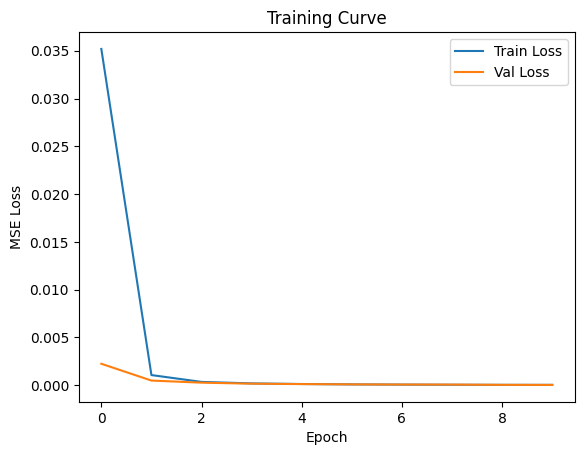

In [13]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Curve")
plt.show()


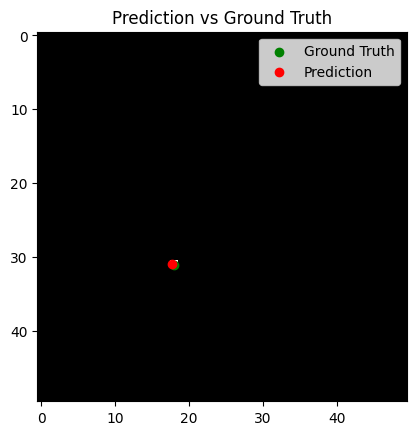

In [14]:
model.eval()

idx = np.random.randint(0, len(X_val))
image = torch.tensor(X_val[idx] / 255.0).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    pred = model(image).cpu().numpy()[0] * 49

gt = y_val[idx]

plt.imshow(X_val[idx], cmap="gray")
plt.scatter(gt[0], gt[1], c="green", label="Ground Truth")
plt.scatter(pred[0], pred[1], c="red", label="Prediction")
plt.legend()
plt.title("Prediction vs Ground Truth")
plt.show()


Mean Absolute Error (X): 0.2000 pixels
Mean Absolute Error (Y): 0.1975 pixels
Mean Euclidean Distance Error: 0.3100 pixels


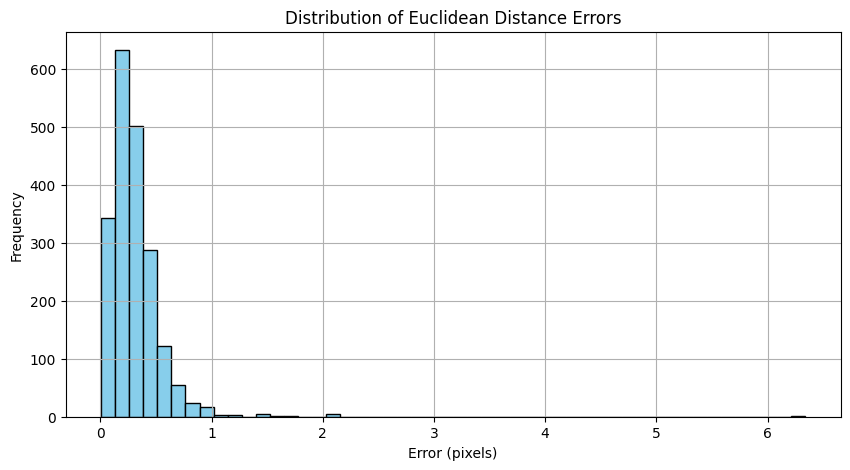

In [15]:
model.eval()
all_preds = []
all_gts = []

with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        outputs = model(images)
        all_preds.append(outputs.cpu().numpy() * 49)
        all_gts.append(targets.numpy() * 49)

all_preds = np.vstack(all_preds)
all_gts = np.vstack(all_gts)

# Calculate Mean Absolute Error in pixels
mae_x = np.mean(np.abs(all_preds[:, 0] - all_gts[:, 0]))
mae_y = np.mean(np.abs(all_preds[:, 1] - all_gts[:, 1]))
dist_err = np.sqrt(np.sum((all_preds - all_gts)**2, axis=1))
mean_dist_err = np.mean(dist_err)

print(f"Mean Absolute Error (X): {mae_x:.4f} pixels")
print(f"Mean Absolute Error (Y): {mae_y:.4f} pixels")
print(f"Mean Euclidean Distance Error: {mean_dist_err:.4f} pixels")

# Visualization of error distribution
plt.figure(figsize=(10, 5))
plt.hist(dist_err, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Euclidean Distance Errors")
plt.xlabel("Error (pixels)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Qualitative Results: Ground Truth vs Predicted Coordinates


In [16]:
def visualize_prediction(model, image, gt_coord, device):
    """
    Displays the image with ground truth and predicted pixel coordinates.
    """
    model.eval()

    # Prepare image tensor
    img_tensor = (
        torch.tensor(image / 255.0)
        .unsqueeze(0)
        .unsqueeze(0)
        .to(device)
    )

    # Predict
    with torch.no_grad():
        pred_coord = model(img_tensor).cpu().numpy()[0] * 49

    gt_x, gt_y = gt_coord
    pred_x, pred_y = pred_coord

    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap="gray")
    plt.scatter(gt_x, gt_y, c="green", s=80, label="Ground Truth")
    plt.scatter(pred_x, pred_y, c="red", s=80, label="Prediction")
    plt.legend()
    plt.title(
        f"GT: ({gt_x:.0f}, {gt_y:.0f}) | "
        f"Pred: ({pred_x:.2f}, {pred_y:.2f})"
    )
    plt.axis("off")
    plt.show()


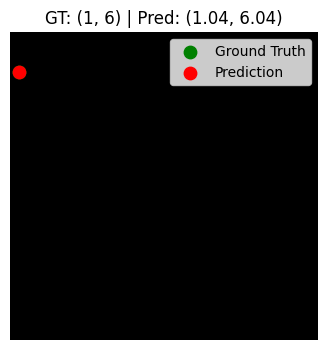

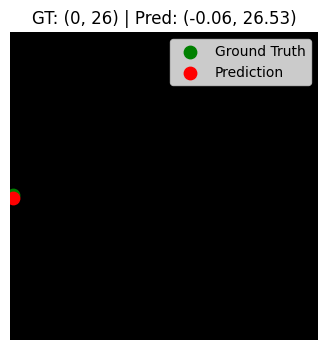

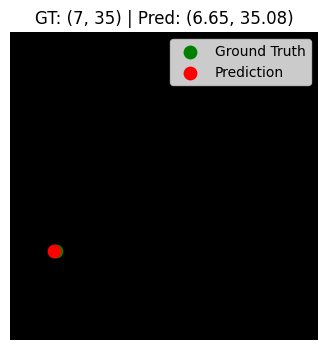

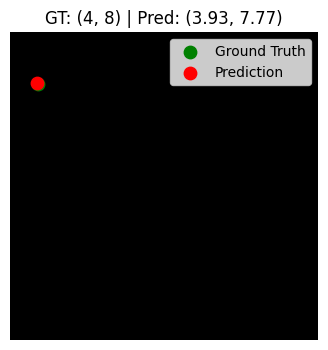

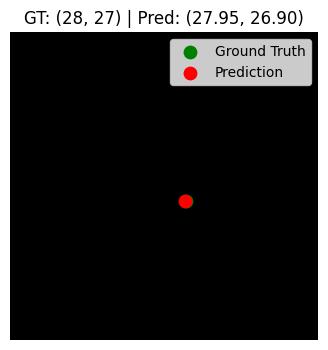

In [17]:
for _ in range(5):
    idx = np.random.randint(0, len(X_val))
    visualize_prediction(
        model,
        X_val[idx],
        y_val[idx],
        device
    )
